In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_cv
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.applications import MobileNetV3Large
from keras import  Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.metrics import Precision, Recall, F1Score, TopKCategoricalAccuracy
from keras.layers import RandomRotation, RandomZoom
from keras_cv.layers import RandomCutout
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input


2025-11-01 01:40:44.126622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761961244.332368      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761961244.389009      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# GLOBAL VARIABLES
IMG_SIZE = (200, 200)
BATCH_SIZE = 96
VALIDATION_LOCATION = '/kaggle/input/asl-dataset-corrected/asl-test_corrected'
FINETUNNING_LOCATION = '/kaggle/input/asl-finetuning/Finetune_alphabet'
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
EPOCHS = 25
N_CLASSES = 29

In [3]:
def get_metrics():
    return  [ Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1_score', average='macro'),
            TopKCategoricalAccuracy(name='top_k_cat_acc'),
        ]

In [4]:
def get_callbacks(model_name, metric):
   
    val_metric = 'val_' + metric
    # Model Checkpoint
    ckpt_cb = keras.callbacks.ModelCheckpoint((model_name + '_best.weights.h5'),
                                             monitor= val_metric,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='max')
    # Early Stopping
    es_cb = keras.callbacks.EarlyStopping(
        monitor=val_metric,  
        mode='min',          
        patience=5,        
        restore_best_weights=True 
    )

    return [ckpt_cb, es_cb]

In [5]:
def create_transfer_model(n_classes, input_shape=(200, 200, 3)):
    
    inputs = Input(shape=input_shape, name="input_layer")
    
    base_model = MobileNetV3Large(
        input_tensor=inputs,
        weights='imagenet',  
        include_top=False,   
        pooling=None        
    )   
    base_model.trainable = False
    x = base_model.output

    x = GlobalAveragePooling2D(name="global_avg_pool")(x)
    
    # Now add the classifier head you defined
    x = Dense(256, activation="relu", name="dense_head_1")(x)
    x = Dropout(0.5, name="dropout_head")(x)
    
    # The output layer for n_classes
    outputs = Dense(n_classes, activation="softmax", name="output_layer", dtype="float32")(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [6]:
def compile_model(model, optimizer, loss, metrics):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

# Data Set

In [7]:
def preprocess(img, label):

    img = tf.cast(img, tf.float32) 
    img = tf.image.resize(img, IMG_SIZE)
    img_preprocessed = preprocess_input(img)
    if label == 26:
        label = 27
    label = tf.one_hot(label, depth=N_CLASSES)

    return img_preprocessed, label

In [8]:
random_rotation = RandomRotation(factor=(-0.18, 0.18), dtype=tf.float32)
random_cutout = RandomCutout(height_factor=0.05, width_factor=0.05, dtype=tf.float32)
random_zoom = RandomZoom(height_factor=0.1, width_factor=0.1, dtype=tf.float32)

I0000 00:00:1761961263.457049      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [9]:
def augment_pre_batch(img, label):
    # Apply augmentations randomly
    if tf.random.uniform([]) < 0.5:
        img = random_rotation(img)

    if tf.random.uniform([]) < 0.5:
        img = random_cutout(img)

    if tf.random.uniform([]) < 0.5:
        img = random_zoom(img)

    return img, label


In [10]:
def build_data_set(folder_loc, split=None, image_size=IMG_SIZE, batch_size=BATCH_SIZE, isTrain=False, data_augmentation=False):
    
    loader_args = {
        'directory': folder_loc,
        'image_size': image_size,
        'seed': SEED,
        'label_mode': 'int',
        'batch_size': None
    }

    if split:
        loader_args['validation_split'] = split
        loader_args['subset'] = "training" if isTrain else "validation"
    
    ds = keras.preprocessing.image_dataset_from_directory(**loader_args)


    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)

    if isTrain:
        #ds = ds.cache()
        ds = ds.shuffle(buffer_size=256)
    
    if isTrain and data_augmentation:
       ds = ds.map(augment_pre_batch, num_parallel_calls=AUTOTUNE)


    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(AUTOTUNE)
    

    return ds

In [11]:
train_ds = build_data_set(FINETUNNING_LOCATION, split=0.2, isTrain=True, data_augmentation=True)
test_ds = build_data_set(FINETUNNING_LOCATION, split=0.2, isTrain=False) 

Found 2700 files belonging to 27 classes.
Using 2160 files for training.
Found 2700 files belonging to 27 classes.
Using 540 files for validation.


# FINE TUNIG

In [12]:
cnn_tl_model = create_transfer_model(N_CLASSES) 
weights = '/kaggle/input/signlanguagemobilenetv3/keras/default/1/MobileNetV3_best.weights.h5'
cnn_tl_model.load_weights(weights)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Freeze and Unfreze layers
FINE_TUNE_LAYERS = 15

inner_layers = cnn_tl_model.layers

for layer in inner_layers[:-FINE_TUNE_LAYERS]:
    layer.trainable = False

for layer in inner_layers[-FINE_TUNE_LAYERS:]:
    layer.trainable = True
    print(f"Unfrozen Layer: {layer.name}")

Unfrozen Layer: expanded_conv_14_squeeze_excite_conv
Unfrozen Layer: expanded_conv_14_squeeze_excite_relu
Unfrozen Layer: expanded_conv_14_squeeze_excite_conv_1
Unfrozen Layer: re_lu_18
Unfrozen Layer: expanded_conv_14_squeeze_excite_mul
Unfrozen Layer: expanded_conv_14_project
Unfrozen Layer: expanded_conv_14_project_bn
Unfrozen Layer: expanded_conv_14_add
Unfrozen Layer: conv_1
Unfrozen Layer: conv_1_bn
Unfrozen Layer: activation_19
Unfrozen Layer: global_avg_pool
Unfrozen Layer: dense_head_1
Unfrozen Layer: dropout_head
Unfrozen Layer: output_layer


In [14]:
loss_tl = keras.losses.CategoricalCrossentropy(label_smoothing=0.02)
opt_finetune = keras.optimizers.Adam(learning_rate=1e-5)
all_callbacks = get_callbacks('MobileNetV3_finetune', 'f1_score') 

compile_model(cnn_tl_model, opt_finetune, loss_tl, get_metrics())

In [15]:
history_finetune = cnn_tl_model.fit(
    train_ds, 
    validation_data=test_ds, 
    epochs=15, 
    callbacks=all_callbacks, 
    verbose=1
)

Epoch 1/15


I0000 00:00:1761961281.692482      57 service.cc:148] XLA service 0x7cbbb8213810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761961281.693498      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761961283.540162      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - f1_score: 0.0998 - loss: 5.3791 - precision: 0.1620 - recall: 0.0718 - top_k_cat_acc: 0.3380 

I0000 00:00:1761961290.700011      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 737ms/step - f1_score: 0.0993 - loss: 5.4276 - precision: 0.1447 - recall: 0.0614 - top_k_cat_acc: 0.3480 - val_f1_score: 0.1578 - val_loss: 4.8664 - val_precision: 0.2189 - val_recall: 0.1208 - val_top_k_cat_acc: 0.4729
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - f1_score: 0.0976 - loss: 5.2223 - precision: 0.1315 - recall: 0.0527 - top_k_cat_acc: 0.3420 - val_f1_score: 0.1584 - val_loss: 4.6438 - val_precision: 0.2205 - val_recall: 0.1167 - val_top_k_cat_acc: 0.4729
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - f1_score: 0.1240 - loss: 4.9702 - precision: 0.1865 - recall: 0.0673 - top_k_cat_acc: 0.3548 - val_f1_score: 0.1782 - val_loss: 4.4751 - val_precision: 0.2481 - val_recall: 0.1354 - val_top_k_cat_acc: 0.4875
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 469ms/step - f1_score: 0.1180 - loss: 4.7484 - precision: 0.1568 - recall: 0.0545 - top_k_cat_acc: 0.3661 - val_f1_score: 0.1665 - val_loss: 4.3846 - val_precision: 0.2460 - val_re

In [16]:
def graph_history_metrics(history, metrics, display_metric):

    val_dp_metric = 'val_' + display_metric
    
    best_epoch = np.argmax(history.history[val_dp_metric])
    best_score = history.history[val_dp_metric][best_epoch]
    print('>>> Best Epoch: ', best_epoch+1)
    
    epochs_range = range(1, len(history.history[display_metric]) + 1)
    plt.figure(figsize=(12, 15))
        
    cols = 2
    rows = math.ceil(len(metrics) / cols)
    
    for i, metric_name in enumerate(metrics):
        
        if metric_name not in history.history:
            print(f"Warning: Metric '{metric_name}' not found in history. Skipping plot.")
            continue
        
        val_metric_name = 'val_' + metric_name
        if val_metric_name not in history.history:
            print(f"Warning: Validation metric '{val_metric_name}' not found in history. Skipping plot.")
            continue
    
        metric = history.history[metric_name]
        val_metric = history.history[val_metric_name]
        
    
        plt.subplot(rows, cols, i + 1)
        
        plt.plot(epochs_range, metric, label='Training')
        plt.plot(epochs_range, val_metric, label='Validation')
        
        plt.title(metric_name.replace('_', ' ').capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric_name.capitalize())
        plt.legend()
        plt.grid()
    
    
    plt.tight_layout()
    plt.show()

>>> Best Epoch:  3


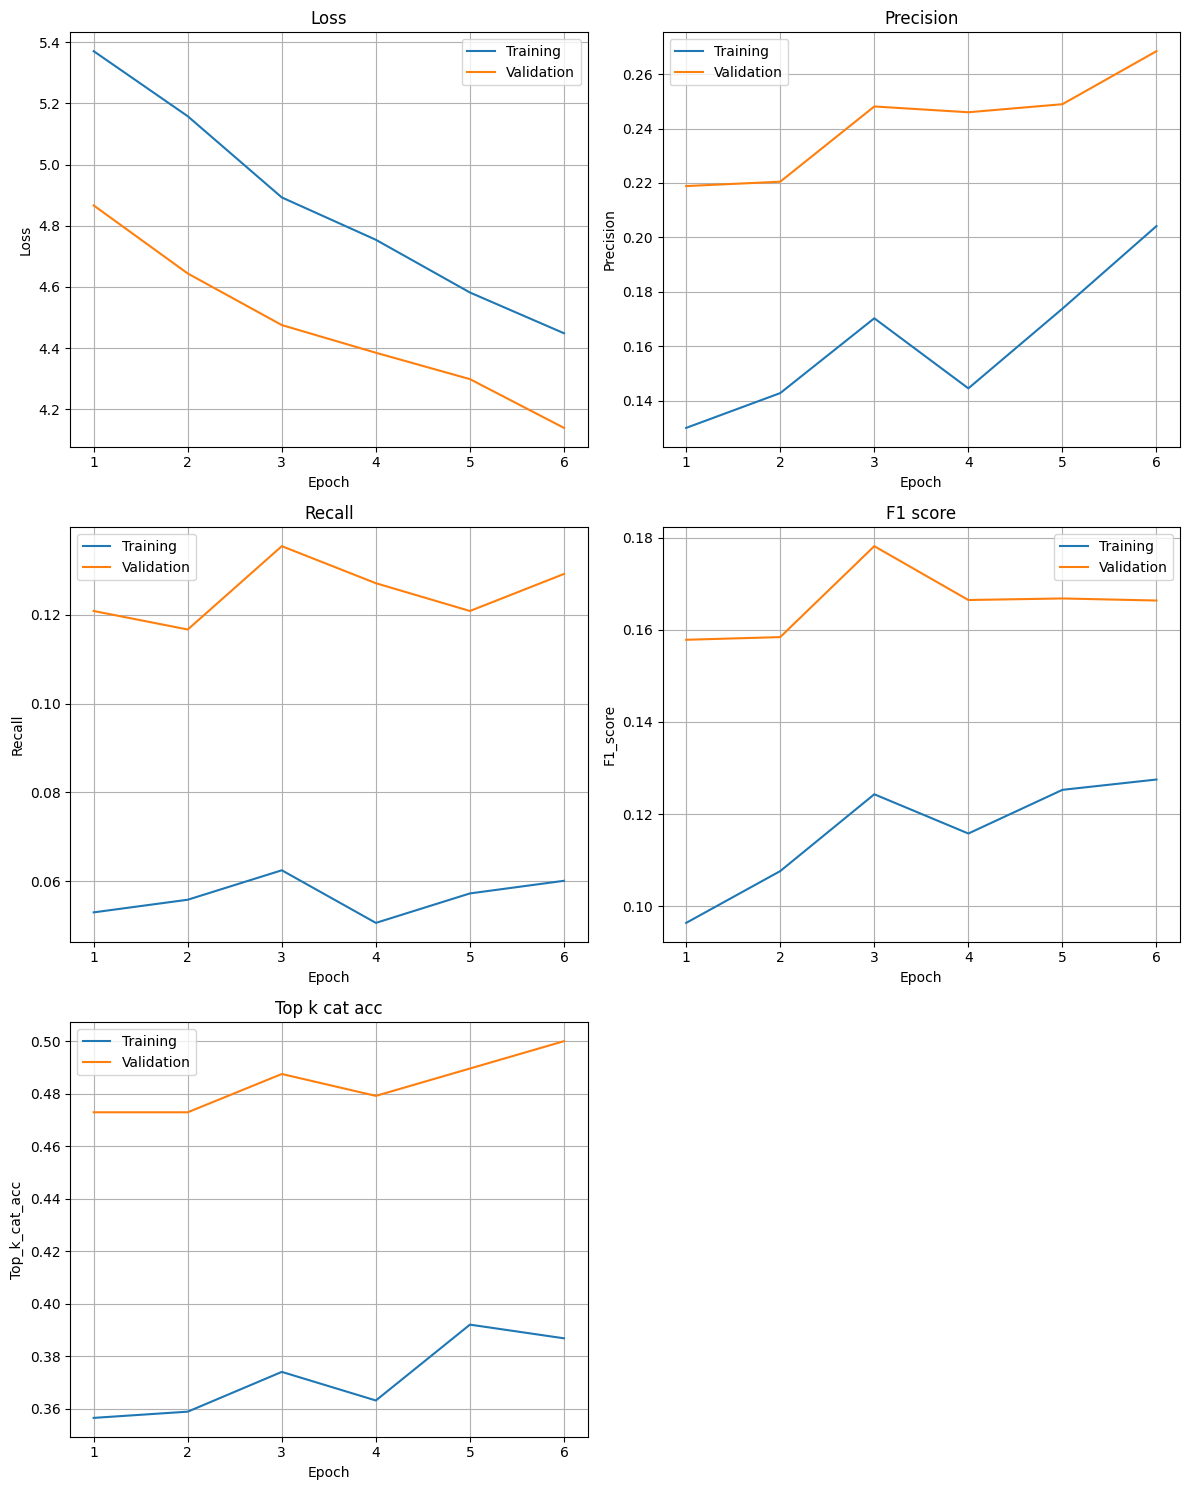

In [17]:
metrics = ['loss', 'precision', 'recall', 'f1_score', 'top_k_cat_acc']
graph_history_metrics(history_finetune, metrics, metrics[3])

In [18]:
cnn_tl_model.save('mobilenet_sign_language_model.keras')

In [19]:
valid_ds = build_data_set(VALIDATION_LOCATION, isTrain=False) 

Found 870 files belonging to 29 classes.


In [20]:
validation = cnn_tl_model.evaluate(valid_ds, verbose=1, return_dict=True)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - f1_score: 0.2024 - loss: 4.3580 - precision: 0.2779 - recall: 0.1687 - top_k_cat_acc: 0.5286


In [21]:
print(validation)

{'f1_score': 0.21087215840816498, 'loss': 4.283156871795654, 'precision': 0.2742857038974762, 'recall': 0.1666666716337204, 'top_k_cat_acc': 0.53125}
